In [2]:
# Collect videos from a directory
import os

video_directory = 'C:/Users/nihal/Desktop/Academics/Main/MainProject/Main_Project/Project/videos'
videos = []
for filename in os.listdir(video_directory):
    if filename.endswith('.mp4'):
        videos.append(os.path.join(video_directory, filename))

In [3]:
# Resize videos to a standard size
import cv2

width, height = 640, 360

for video in videos:
    cap = cv2.VideoCapture(video)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (width, height))
        frames.append(frame)
    cap.release()

    # Save resized frames to disk
    video_name = os.path.splitext(os.path.basename(video))[0]
    for i, frame in enumerate(frames):
        filename = f'{video_name}_frame{i:03}.jpg'
        cv2.imwrite(os.path.join('C:/Users/nihal/Desktop/Academics/Main/MainProject/Main_Project/Project/frame', filename), frame)

In [4]:
import os
import cv2
import numpy as np
from glob import glob

# Define the function to extract frames from a video
def extract_frames(video):
    cap = cv2.VideoCapture(video)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_per_segment = frame_count // num_frames
    frames = []

    for i in range(num_frames):
        frame_number = i * frames_per_segment
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()
        frame = cv2.resize(frame, (width, height))
        frames.append(frame)

    cap.release()
    frames = np.array(frames)
    return frames

# Define the function to extract features from videos
def extract_features(videos):
    features = []

    for video in videos:
        frames = extract_frames(video)
        features.append(frames)

    features = np.array(features)
    return features

# Set the parameters for feature extraction
num_frames = 16
width = 224
height = 224

# Define the path to your data directory
data_dir = 'C:/Users/nihal/Desktop/Academics/Main/MainProject/Main_Project/Project/videos'

# Get a list of file paths to your videos
videos = glob(os.path.join(data_dir, 'C:/Users/nihal/Desktop/Academics/Main/MainProject/Main_Project/Project/videos/Crowd_Video.mp4'))

# Extract features from the videos
X = extract_features(videos)

# Save the features to a file
np.save('C:/Users/nihal/Desktop/Academics/Main/MainProject/Main_Project/Project/features.npy', X)


Features shape: (1, 16, 224, 224, 3)


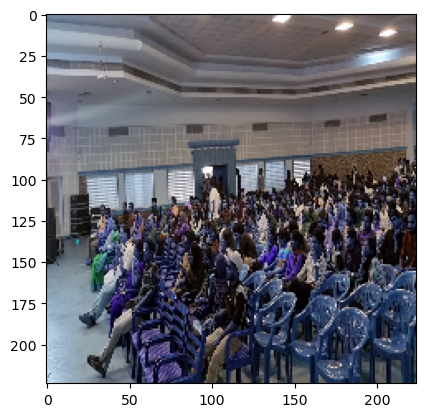

In [5]:
import numpy as np

# Load the features from the file
features = np.load('C:/Users/nihal/Desktop/Academics/Main/MainProject/Main_Project/Project/features.npy')

# Print the shape of the features array
print('Features shape:', features.shape)

# Display the first video's first frame
import matplotlib.pyplot as plt
plt.imshow(features[0][0])
plt.show()

In [ ]:
import os
import subprocess
import xml.etree.ElementTree as ET
import cv2
import json

# Define paths
video_path = 'C:/Users/nihal/Desktop/Academics/Main/MainProject/Main_Project/Project/videos'
image_dir = 'path/to/image/directory'
labelimg_path = 'path/to/labelimg/executable'
annotations_dir = 'path/to/annotations/directory'

# Extract frames from video
vidcap = cv2.VideoCapture(video_path)
success,image = vidcap.read()
count = 0
while success:
    image_path = os.path.join(image_dir, f'image_{count:05d}.jpg')
    cv2.imwrite(image_path, image)     # save frame as JPEG file
    success,image = vidcap.read()
    count += 1

# Run LabelImg for image annotation
subprocess.run([labelimg_path, image_dir])

# Parse LabelImg XML annotations and save as JSON
annotations = []
for filename in os.listdir(annotations_dir):
    if filename.endswith('.xml'):
        xml_path = os.path.join(annotations_dir, filename)
        tree = ET.parse(xml_path)
        root = tree.getroot()
        annotation = {
            'file_name': root.find('filename').text,
            'count': len(root.findall("./object[name='person']"))
        }
        annotations.append(annotation)
annotations_path = os.path.join(annotations_dir, 'annotations.json')
with open(annotations_path, 'w') as f:
    json.dump(annotations, f)


In [9]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

class CrowdDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        with open(os.path.join(data_path, 'C:/Users/nihal/Desktop/Academics/Main/MainProject/Main_Project/Project/annotations.json'), 'r') as f:
            self.annotations = json.load(f)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.data_path, self.annotations[index]['file_name'])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        count = self.annotations[index]['count']

        if self.transform is not None:
            img = self.transform(img)

        return img, count

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

from dataset import CrowdDataset # custom dataset class
from model import HybridAttentionModel # custom model class

# set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# set hyperparameters
lr = 1e-4
batch_size = 32
num_epochs = 50

# create dataset and data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # normalize image pixels
])
train_dataset = CrowdDataset('C:/Users/nihal/Desktop/Academics/Main/MainProject/Main_Project/Project', transform=transform)
val_dataset = CrowdDataset('C:/Users/nihal/Desktop/Academics/Main/MainProject/Main_Project/Project', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# create model and optimizer
model = HybridAttentionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# training loop
for epoch in range(num_epochs):
    # train model
    model.train()
    train_loss = 0
    for i, (images, targets) in enumerate(train_loader):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    # evaluate model on validation set
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (images, targets) in enumerate(val_loader):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
        val_loss /= len(val_loader)
    
    # print epoch and loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# save model
torch.save(model.state_dict(), 'C:/Users/nihal/Desktop/Academics/Main/MainProject/Main_Project/Project')


ModuleNotFoundError: No module named 'dataset'